In [234]:
from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt

In [239]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('model_data.csv', 
                   parse_dates = [['year', 'month', 'day', 'hour']],
                  index_col = 0, date_parser = parse)


In [240]:
dataset.head()

,RTLMP,LOAD,WIND,OUTAGES
year_month_day_hour,,,,
2014-01-01 01:00:00,24.6750,35886.713705,7461.49,8492
2014-01-01 02:00:00,24.5225,35587.349910,7281.48,8496
2014-01-01 03:00:00,24.1975,35332.870128,7130.77,8496
2014-01-01 04:00:00,24.0400,35211.064380,7336.28,8496
2014-01-01 05:00:00,24.1275,35490.158245,7333.28,8496


In [251]:
def series_to_supervised(data, n_in, n_out, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' %(j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [252]:
values = dataset.values
reframed = series_to_supervised(values, 24, 1)
reframed.drop(reframed.columns[[97,98,99]], axis=1, inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(reframed.values)
scaled = DataFrame(scaled)
scaled.columns = reframed.columns

In [253]:
print(values.shape)
print(reframed.shape)
reframed.head()

(40695, 4)
(40671, 97)


,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var1(t-22),var2(t-22),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
24,24.6750,35886.713705,7461.49,8492.0,24.5225,35587.349910,7281.48,8496.0,24.1975,35332.870128,...,7511.0,21.3675,33050.660433,7350.73,8114.0,20.3000,31931.087945,7506.69,8083.0,20.6950
25,24.5225,35587.349910,7281.48,8496.0,24.1975,35332.870128,7130.77,8496.0,24.0400,35211.064380,...,8114.0,20.3000,31931.087945,7506.69,8083.0,20.6950,31244.362015,7541.20,9288.0,21.2375
26,24.1975,35332.870128,7130.77,8496.0,24.0400,35211.064380,7336.28,8496.0,24.1275,35490.158245,...,8083.0,20.6950,31244.362015,7541.20,9288.0,21.2375,31172.024978,7246.84,9319.0,21.9175
27,24.0400,35211.064380,7336.28,8496.0,24.1275,35490.158245,7333.28,8496.0,24.6600,36203.492735,...,9288.0,21.2375,31172.024978,7246.84,9319.0,21.9175,31629.997463,7027.72,9499.0,22.8475
28,24.1275,35490.158245,7333.28,8496.0,24.6600,36203.492735,7407.28,8496.0,25.0950,37084.806113,...,9319.0,21.9175,31629.997463,7027.72,9499.0,22.8475,32667.439115,6580.31,9499.0,24.9975


In [257]:
inv_reframed = scaler.inverse_transform(scaled)
inv_reframed

array([[2.46750000e+01, 3.58867137e+04, 7.46149000e+03, ...,
        7.50669000e+03, 8.08300000e+03, 2.06950000e+01],
       [2.45225000e+01, 3.55873499e+04, 7.28148000e+03, ...,
        7.54120000e+03, 9.28800000e+03, 2.12375000e+01],
       [2.41975000e+01, 3.53328701e+04, 7.13077000e+03, ...,
        7.24684000e+03, 9.31900000e+03, 2.19175000e+01],
       ...,
       [1.52900000e+01, 4.09518000e+04, 1.11659500e+04, ...,
        1.49114200e+04, 4.65100000e+03, 1.50750000e+01],
       [1.61750000e+01, 4.20928700e+04, 1.09069100e+04, ...,
        1.46137900e+04, 4.65100000e+03, 1.59250000e+01],
       [1.81650000e+01, 4.44327800e+04, 1.10227800e+04, ...,
        1.42679600e+04, 4.24500000e+03, 1.70400000e+01]])

In [254]:
print(scaled.shape)
scaled.head()

(40671, 97)


,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var1(t-22),var2(t-22),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
0,0.010617,0.240545,0.365617,0.250433,0.010583,0.234462,0.356757,0.250572,0.010511,0.229292,...,0.216448,0.009883,0.182921,0.360166,0.237338,0.009647,0.160174,0.367842,0.236264,0.009734
1,0.010583,0.234462,0.356757,0.250572,0.010511,0.229292,0.349339,0.250572,0.010476,0.226817,...,0.237338,0.009647,0.160174,0.367842,0.236264,0.009734,0.146221,0.369540,0.278009,0.009854
2,0.010511,0.229292,0.349339,0.250572,0.010476,0.226817,0.359454,0.250572,0.010496,0.232488,...,0.236264,0.009734,0.146221,0.369540,0.278009,0.009854,0.144751,0.355052,0.279083,0.010005
3,0.010476,0.226817,0.359454,0.250572,0.010496,0.232488,0.359307,0.250572,0.010614,0.246981,...,0.278009,0.009854,0.144751,0.355052,0.279083,0.010005,0.154056,0.344267,0.285318,0.010212
4,0.010496,0.232488,0.359307,0.250572,0.010614,0.246981,0.362949,0.250572,0.010710,0.264888,...,0.279083,0.010005,0.154056,0.344267,0.285318,0.010212,0.175135,0.322246,0.285318,0.010689


In [277]:
values = scaled.values
n_train_hours = 365*24*3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("Training features:", train_X.shape)
print("Training targets:", train_y.shape)

print("Testing features:", test_X.shape)
print("Testing targets:", test_y.shape)


Training features: (26280, 96)
Training targets: (26280,)
Testing features: (14391, 96)
Testing targets: (14391,)


In [278]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Training:", train_X.shape, train_y.shape)
print("Testing:", test_X.shape, test_y.shape)

Training: (26280, 1, 96) (26280,)
Testing: (14391, 1, 96) (14391,)


Train on 26280 samples, validate on 14391 samples
Epoch 1/50
 - 3s - loss: 0.0089 - val_loss: 0.0062
Epoch 2/50
 - 2s - loss: 0.0071 - val_loss: 0.0081
Epoch 3/50
 - 2s - loss: 0.0056 - val_loss: 0.0033
Epoch 4/50
 - 2s - loss: 0.0047 - val_loss: 0.0038
Epoch 5/50
 - 2s - loss: 0.0037 - val_loss: 0.0130
Epoch 6/50
 - 2s - loss: 0.0045 - val_loss: 0.0046
Epoch 7/50
 - 2s - loss: 0.0027 - val_loss: 0.0038
Epoch 8/50
 - 2s - loss: 0.0032 - val_loss: 0.0052
Epoch 9/50
 - 2s - loss: 0.0028 - val_loss: 0.0037
Epoch 10/50
 - 2s - loss: 0.0021 - val_loss: 0.0030
Epoch 11/50
 - 2s - loss: 0.0021 - val_loss: 0.0025
Epoch 12/50
 - 2s - loss: 0.0022 - val_loss: 0.0024
Epoch 13/50
 - 2s - loss: 0.0023 - val_loss: 0.0035
Epoch 14/50
 - 2s - loss: 0.0036 - val_loss: 0.0024
Epoch 15/50
 - 2s - loss: 0.0024 - val_loss: 0.0042
Epoch 16/50
 - 2s - loss: 0.0025 - val_loss: 0.0034
Epoch 17/50
 - 2s - loss: 0.0023 - val_loss: 0.0036
Epoch 18/50
 - 2s - loss: 0.0024 - val_loss: 0.0038
Epoch 19/50
 - 2s - los

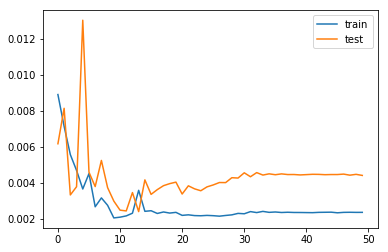

In [279]:
model = Sequential()
model.add(LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss = "mae", optimizer = 'adam')

history = model.fit(train_X, train_y, epochs = 50, batch_size = 72,
                   validation_data = (test_X, test_y), verbose = 2,
                   shuffle = False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [280]:
yhat = model.predict(test_X)
print(yhat.shape)
print(yhat)

(14391, 1)
[[0.01042091]
 [0.01052223]
 [0.0104663 ]
 ...
 [0.00820158]
 [0.0084091 ]
 [0.00863162]]


In [281]:
test_y

array([0.0097114 , 0.00957107, 0.0095267 , ..., 0.00848728, 0.00867586,
       0.00892324])

In [282]:
test_X2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X2.shape

(14391, 96)

In [287]:
inv_yhat = concatenate((test_X2[:, 0:],yhat), axis = 1)
print(inv_yhat.shape)
inv_yhat[:,96]

(14391, 97)


array([0.01042091, 0.01052223, 0.0104663 , ..., 0.00820158, 0.0084091 ,
       0.00863162])

In [285]:
test_y = test_y.reshape((len(test_y), 1))
y_actuals = concatenate((test_X2[:, 0:], test_y), axis = 1)

In [288]:
y_actuals.shape
y_actuals[:, 96]

array([0.0097114 , 0.00957107, 0.0095267 , ..., 0.00848728, 0.00867586,
       0.00892324])

In [289]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yactuals = scaler.inverse_transform(y_actuals)

In [294]:
print(inv_yhat.shape)
inv_yhat

(14391, 97)


array([[1.98900000e+01, 3.42024989e+04, 6.35563000e+03, ...,
        3.98496000e+03, 7.81400000e+03, 2.37904857e+01],
       [2.00825000e+01, 3.35654744e+04, 5.18922000e+03, ...,
        3.83454000e+03, 7.81400000e+03, 2.42471790e+01],
       [2.00575000e+01, 3.27788754e+04, 4.22310000e+03, ...,
        4.81992000e+03, 7.81400000e+03, 2.39950771e+01],
       ...,
       [1.52900000e+01, 4.09518000e+04, 1.11659500e+04, ...,
        1.49114200e+04, 4.65100000e+03, 1.37872293e+01],
       [1.61750000e+01, 4.20928700e+04, 1.09069100e+04, ...,
        1.46137900e+04, 4.65100000e+03, 1.47226250e+01],
       [1.81650000e+01, 4.44327800e+04, 1.10227800e+04, ...,
        1.42679600e+04, 4.24500000e+03, 1.57255755e+01]])

In [295]:
print(inv_yactuals.shape)
inv_yactuals

(14391, 97)


array([[1.98900000e+01, 3.42024989e+04, 6.35563000e+03, ...,
        3.98496000e+03, 7.81400000e+03, 2.05925000e+01],
       [2.00825000e+01, 3.35654744e+04, 5.18922000e+03, ...,
        3.83454000e+03, 7.81400000e+03, 1.99600000e+01],
       [2.00575000e+01, 3.27788754e+04, 4.22310000e+03, ...,
        4.81992000e+03, 7.81400000e+03, 1.97600000e+01],
       ...,
       [1.52900000e+01, 4.09518000e+04, 1.11659500e+04, ...,
        1.49114200e+04, 4.65100000e+03, 1.50750000e+01],
       [1.61750000e+01, 4.20928700e+04, 1.09069100e+04, ...,
        1.46137900e+04, 4.65100000e+03, 1.59250000e+01],
       [1.81650000e+01, 4.44327800e+04, 1.10227800e+04, ...,
        1.42679600e+04, 4.24500000e+03, 1.70400000e+01]])

In [346]:
actuals = inv_yactuals[:,96]
predicted = inv_yhat[:,96]
results_df = DataFrame({'predicted':predicted,'actuals':actuals})
rmse = sqrt(mean_squared_error(results_df['actuals'], results_df['predicted']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 49.273


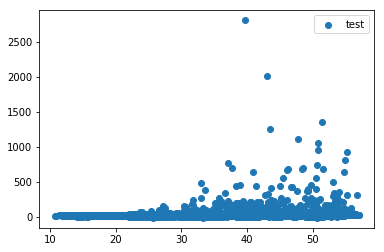

In [347]:
pyplot.scatter(x = predicted, y = actuals, label='test')
pyplot.legend()
pyplot.show()

In [340]:
df.head(50)

,actuals,predicted
0,20.5925,23.790486
1,19.9600,24.247179
2,19.7600,23.995077
3,19.5600,23.467324
4,19.3875,22.399862
5,19.4625,22.758780
6,20.1100,22.727121
7,20.0550,23.657618
8,19.4375,23.484123
9,18.9725,22.433507
